# Brain Tumor Classification - Baseline CNN Model

This notebook implements a baseline CNN model for brain tumor classification using PyTorch. We'll use the preprocessed brain tumor MRI dataset to train and evaluate a simple CNN architecture.

## 1. Setup and Imports

In [2]:
# !pip install split-folders
# !pip install kagglehub

: 

In [1]:
# Standard library imports
import os
import pathlib
from typing import Tuple, Dict, List

# Data processing and visualization
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Dataset
import kagglehub

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

: 

## 2. Data Loading and Preprocessing

In [7]:
def setup_data(batch_size: int = 64) -> Tuple[DataLoader, DataLoader]:
    """
    Set up data loaders for training and validation.
    
    Args:
        batch_size: Number of samples per batch
        
    Returns:
        train_loader, val_loader: DataLoader objects for training and validation
    """
    # Download dataset
    path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
    data_dir = pathlib.Path(path)
    
    # Define transformations
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((128,128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    # Create datasets
    train_set = torchvision.datasets.ImageFolder(
        data_dir.joinpath('Training'), 
        transform=transform
    )
    val_set = torchvision.datasets.ImageFolder(
        data_dir.joinpath('Testing'), 
        transform=transform
    )
    
    # Create data loaders
    train_loader = DataLoader(
        train_set, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=2, 
        pin_memory=True
    )
    val_loader = DataLoader(
        val_set, 
        batch_size=batch_size, 
        shuffle=False,  # No need to shuffle validation data
        num_workers=2, 
        pin_memory=True
    )
    
    print(f'Training samples: {len(train_set)}')
    print(f'Validation samples: {len(val_set)}')
    print(f'Number of classes: {len(train_set.classes)}')
    print(f'Classes: {train_set.classes}')
    
    return train_loader, val_loader

# Set up data loaders
train_loader, val_loader = setup_data(batch_size=64)

Resuming download from 0 bytes (155791278 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/masoudnickparvar/brain-tumor-mri-dataset?dataset_version_number=1 (0/155791278) bytes left.


100%|██████████| 149M/149M [00:04<00:00, 38.1MB/s] 

Extracting model files...


Path to dataset files: /Users/bengriffin/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


## 3. Model Architecture

In [8]:
class BrainTumorCNN(nn.Module):
    """
    CNN architecture for brain tumor classification.
    
    Architecture:
    - 4 convolutional blocks (each with Conv2d, BatchNorm2d, LeakyReLU, MaxPool2d)
    - 2 fully connected layers with dropout
    """
    def __init__(self, num_classes: int = 4):
        super(BrainTumorCNN, self).__init__()
        
        # Convolutional layers
        self.features = nn.Sequential(
            # First conv block
            nn.Conv2d(1, 16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            
            # Second conv block
            nn.Conv2d(16, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            
            # Third conv block
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            
            # Fourth conv block
            nn.Conv2d(64, 128, kernel_size=5),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(2)
        )
        
        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.5),  # Add dropout to prevent overfitting
            nn.Linear(1024, num_classes)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.classifier(x)
        return x

# Initialize model
model = BrainTumorCNN().to(device)
print(model)

['Training', 'Testing']

In [16]:
class CNNModel(nn.Module):
  def __init__(self):
    super(CNNModel, self).__init__()

    #Conv 1
    self.cnv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0) #128-5+1=124

    #Max Pool 1
    self.maxpool1 = nn.MaxPool2d(kernel_size=2) #124/2 = 64

    #Conv 2
    self.cnv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0) #60

    #Max Pool 2
    self.maxpool2 = nn.MaxPool2d(kernel_size=2) #30

    #Conv 3
    self.cnv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0) #26

    #Max Pool 3
    self.maxpool3 = nn.MaxPool2d(kernel_size=2) #13

    #Conv 4
    self.cnv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=0) #9

    #Max Pool 4
    self.maxpool4 = nn.MaxPool2d(kernel_size=2) #4

    #Activation Function
    self.leakyRelu = nn.LeakyReLU()

    #Fully connected Layer 1
    self.fc1 = nn.Linear(128*4*4, 1024)

    #Fully connected Layer 2
    # self.fc2 = nn.Linear(1024, 2)
    self.fc2 = nn.Linear(1024, 4)

  def forward(self, x):
    #Layer 1
    out = self.leakyRelu(self.cnv1(x))
    out = self.maxpool1(out)

    #Layer 2
    out = self.leakyRelu(self.cnv2(out))
    out = self.maxpool2(out)

    #Layer 3
    out = self.leakyRelu(self.cnv3(out))
    out = self.maxpool3(out)

    #Layer 4
    out = self.leakyRelu(self.cnv4(out))
    out = self.maxpool4(out)

    #flatten
    out = out.view(out.size(0), -1)

    # Linear Function
    out = self.leakyRelu(self.fc1(out))
    out = self.fc2(out)

    return out



In [17]:
# Training CNN
num_epochs = 10
model = CNNModel()
error = nn.CrossEntropyLoss()

lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [18]:
train_loss_list = []
val_loss_list = []
accuracy_list = []

for epoch in range(num_epochs):
  train_loss = 0
  val_loss = 0
  for i, (images, labels) in enumerate(train_loader):

    optimizer.zero_grad()
    outputs = model(images)
    loss = error(outputs, labels)
    train_loss+=loss.item()
    loss.backward()
    optimizer.step()
    print("Loss in Iteration:", i, ":", loss.item())
  total = 0
  correct = 0
  for images, labels in val_loader:
    outputs = model(images)
    v_loss = error(outputs, labels)
    val_loss+=v_loss.item()
    predicted = torch.max(outputs.data, 1)[1]

    total+=len(labels)
    correct+=(predicted==labels).sum()


  scheduler.step(val_loss/len(val_loader))
  accuracy = 100*correct/float(total)
  train_loss_list.append(train_loss/len(train_loader))
  val_loss_list.append(val_loss/len(val_loader))
  accuracy_list.append(accuracy)
  print("Epoch:{}  Loss:{}  Accuracy:{}%".format(epoch, train_loss/len(train_loader), accuracy))

Loss in Iteration: 0 : 1.385680079460144
Loss in Iteration: 1 : 1.384405255317688
Loss in Iteration: 2 : 1.295916199684143
Loss in Iteration: 3 : 1.238207221031189
Loss in Iteration: 4 : 1.1576206684112549
Loss in Iteration: 5 : 1.2224998474121094
Loss in Iteration: 6 : 1.0726406574249268
Loss in Iteration: 7 : 1.203154444694519
Loss in Iteration: 8 : 1.152618408203125
Loss in Iteration: 9 : 1.2319258451461792
Loss in Iteration: 10 : 1.0976369380950928
Loss in Iteration: 11 : 1.077787160873413
Loss in Iteration: 12 : 1.1686515808105469
Loss in Iteration: 13 : 1.2105135917663574
Loss in Iteration: 14 : 1.0521814823150635
Loss in Iteration: 15 : 1.036082148551941
Loss in Iteration: 16 : 0.9695459604263306
Loss in Iteration: 17 : 1.6267362833023071
Loss in Iteration: 18 : 1.0132482051849365
Loss in Iteration: 19 : 1.2674793004989624
Loss in Iteration: 20 : 1.2143296003341675
Loss in Iteration: 21 : 0.945146381855011
Loss in Iteration: 22 : 1.1774635314941406
Loss in Iteration: 23 : 1.1445

In [19]:
train_loss_list

[0.9799069702625275,
 0.5295246462027232,
 0.3715374368760321,
 0.2516183534430133,
 0.1768830397890674,
 0.1289606891779436,
 0.06018785752563013,
 0.05808649900265866,
 0.05264127182696635,
 0.04046667351536194]

In [20]:
val_loss_list

[0.8229664847964332,
 0.5544903533799308,
 0.5974702537059784,
 0.3285770465930303,
 0.2856074081999915,
 0.12904610325183188,
 0.11435752220097042,
 0.14401850317205703,
 0.13538598420009726,
 0.19105679328952516]

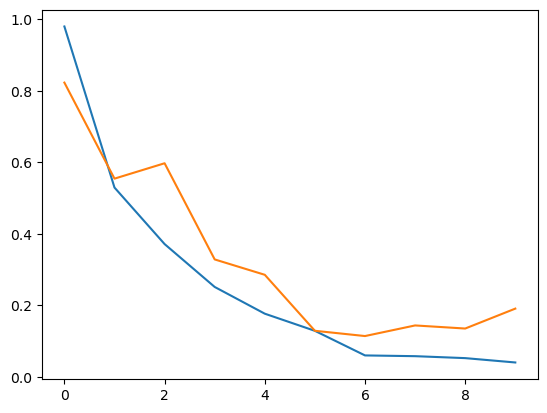

In [21]:
plt.plot(range(num_epochs), train_loss_list)
plt.plot(range(num_epochs), val_loss_list)

In [22]:
accuracy_list

[tensor(65.8276),
 tensor(77.1930),
 tensor(77.8032),
 tensor(87.2616),
 tensor(89.7788),
 tensor(95.0420),
 tensor(95.8047),
 tensor(94.8894),
 tensor(94.8894),
 tensor(94.5843)]

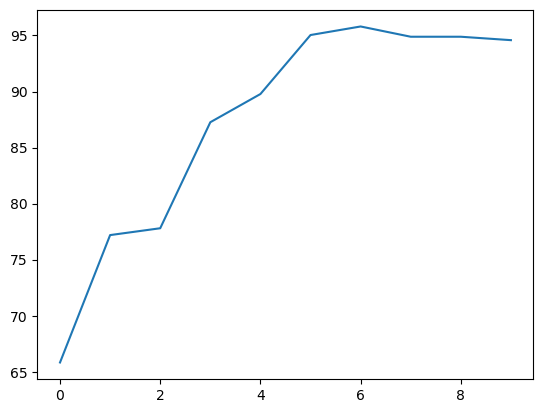

In [23]:
plt.plot(range(num_epochs), accuracy_list)

Text(0.5, 1.0, '2')

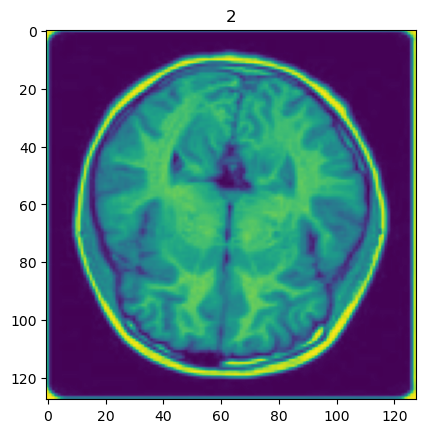

In [24]:
img, label = val_set[1000]
plt.imshow(img.permute(1,2,0))
plt.title(label)

In [25]:
image = img.unsqueeze(0)

with torch.no_grad():
  output = model(image)

_, pred = torch.max(output, 1)
print("Predicted Output:", pred.item())

Predicted Output: 2
